# CHAPTER 2 Local Image Descriptors

* 싸이그래머 - 지각심리학 + 컴퓨터비전 / CVPy 02 [1]
* 김무성

# Contents

* 2.1 Harris Corner Detector
* 2.2 SIFT—Scale-Invariant Feature Transform
* 2.3 Matching Geotagged Images

#2.1 Harris Corner Detector

* Finding Corresponding Points Between Images

<img src="figures/eq2.1.png" />

<img src="figures/eq2.2.png" />

<img src="figures/cap2.1.png" width=600 />

<img src="figures/cap2.2.png"  />

<img src="figures/cap2.3.png" />

#### harris.py

In [1]:
from scipy.ndimage import filters

In [2]:
def compute_harris_response(im,sigma=3):
    """ Compute the Harris corner detector response function
        for each pixel in a graylevel image. """

    # derivatives
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)

    # compute components of the Harris matrix
    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)

    # determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

In [3]:
def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    """ Return corners from a Harris response image
        min_dist is the minimum number of pixels separating 
        corners and image boundary. """
    
    # find top corner candidates above a threshold
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    
    # get coordinates of candidates
    coords = array(harrisim_t.nonzero()).T
    
    # ...and their values
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    
    # sort candidates (reverse to get descending order)
    index = argsort(candidate_values)[::-1]
    
    # store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    
    # select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist), 
                        (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    
    return filtered_coords

In [4]:
def plot_harris_points(image,filtered_coords):
    """ Plots corners found in image. """
    
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords],
                [p[0] for p in filtered_coords],'*')
    axis('off')
    show()

In [5]:
from pylab import *
from numpy import *
from PIL import Image
%matplotlib inline

In [6]:
!ls 

02_Local_Image_Descriptors.ipynb  crans_2_small.jpg  figures	harris.pyc
crans_1_small.jpg		  empire.jpg	     harris.py


In [7]:
import harris

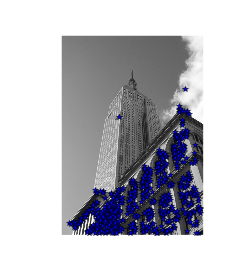

In [8]:
im = array(Image.open('empire.jpg').convert('L'))
harrisim = harris.compute_harris_response(im)
filtered_coords = harris.get_harris_points(harrisim,6)
harris.plot_harris_points(im, filtered_coords)

<img src="figures/fig2.1.png" width=600 />

## Finding Corresponding Points Between Images

<img src="figures/cap2.4.png" />

<img src="figures/eq2.3.png" />

#### harris.py

In [9]:
def get_descriptors(image,filtered_coords,wid=5):
    """ For each point return pixel values around the point
        using a neighbourhood of width 2*wid+1. (Assume points are 
        extracted with min_distance > wid). """
    
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,
                            coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)
    
    return desc

In [10]:
def match(desc1,desc2,threshold=0.5):
    """ For each corner point descriptor in the first image, 
        select its match to second image using
        normalized cross correlation. """
    
    n = len(desc1[0])
    
    # pair-wise distances
    d = -ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n-1) 
            if ncc_value > threshold:
                d[i,j] = ncc_value
            
    ndx = argsort(-d)
    matchscores = ndx[:,0]
    
    return matchscores

In [11]:
def match_twosided(desc1,desc2,threshold=0.5):
    """ Two-sided symmetric version of match(). """
    
    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)
    
    ndx_12 = where(matches_12 >= 0)[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    
    return matches_12

In [12]:
def appendimages(im1,im2):
    """ Return a new image that appends the two images side-by-side. """
    
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))),axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))),axis=0)
    # if none of these cases they are equal, no filling needed.
    
    return concatenate((im1,im2), axis=1)

In [13]:
def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ Show a figure with lines joining the accepted matches 
        input: im1,im2 (images as arrays), locs1,locs2 (feature locations), 
        matchscores (as output from 'match()'), 
        show_below (if images should be shown below matches). """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = vstack((im3,im3))
    
    imshow(im3)
    
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    axis('off')

In [14]:
!ls

02_Local_Image_Descriptors.ipynb  crans_2_small.jpg  figures	harris.pyc
crans_1_small.jpg		  empire.jpg	     harris.py


In [15]:
from pylab import *
from numpy import *
from PIL import Image
%matplotlib inline

In [16]:
import harris

In [17]:
im1 = array(Image.open("crans_1_small.jpg").convert("L"))
im2 = array(Image.open("crans_2_small.jpg").convert("L"))

#from PCV.tools.imtools import imresize
# resize to make matching faster
#im1 = imresize(im1,(im1.shape[1]/2,im1.shape[0]/2))
#im2 = imresize(im2,(im2.shape[1]/2,im2.shape[0]/2))

In [18]:
wid = 5
harrisim = harris.compute_harris_response(im1,5) 
filtered_coords1 = harris.get_harris_points(harrisim,wid+1) 
d1 = harris.get_descriptors(im1,filtered_coords1,wid)

In [19]:
harrisim = harris.compute_harris_response(im2,5) 
filtered_coords2 = harris.get_harris_points(harrisim,wid+1) 
d2 = harris.get_descriptors(im2,filtered_coords2,wid)

In [20]:
print 'starting matching'
matches = harris.match_twosided(d1,d2)

starting matching


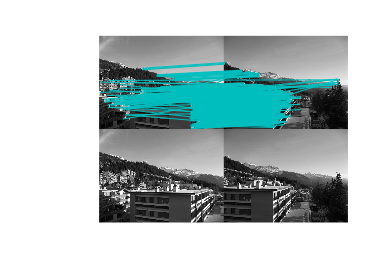

In [21]:
harris.plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches) 

<img src="figures/fig2.2.png" width=600 />

# 2.2 SIFT—Scale-Invariant Feature Transform

* Interest Points
* Descriptor
* Detecting Interest Points
* Matching Descriptors

## Interest Points

<img src="figures/cap2.5.png"  />

## Descriptor

## Detecting Interest Points

<img src="figures/fig2.3.png" width=600 />

<img src="figures/fig2.4.png" width=600 />

#### sift.py

In [6]:
from PIL import Image
from numpy import *
from pylab import *
import os

### 이 코드는 vlfest의 sift 바이너리 파일이 필요하다

#### 다운로드
* http://www.vlfeat.org/download.html 
#### 커맨드라인 설정을 위한 
* http://www.vlfeat.org/install-shell.html

In [24]:
!wget http://www.vlfeat.org/download/vlfeat-0.9.20-bin.tar.gz

--2015-08-04 17:47:58--  http://www.vlfeat.org/download/vlfeat-0.9.20-bin.tar.gz
Resolving www.vlfeat.org (www.vlfeat.org)... 69.163.201.117
접속 www.vlfeat.org (www.vlfeat.org)|69.163.201.117|:80... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 15802008 (15M) [application/x-tar]
Saving to: `vlfeat-0.9.20-bin.tar.gz'

100%[======================================>] 15,802,008  1.03M/s   in 25s     

2015-08-04 17:48:24 (619 KB/s) - `vlfeat-0.9.20-bin.tar.gz' saved [15802008/15802008]



In [25]:
!ls

02_Local_Image_Descriptors.ipynb  empire.sift  sift.py
crans_1_small.jpg		  figures      sift.pyc
crans_2_small.jpg		  harris.py    tmp.pgm
empire.jpg			  harris.pyc   vlfeat-0.9.20-bin.tar.gz


In [27]:
!tar xvfz vlfeat-0.9.20-bin.tar.gz

vlfeat-0.9.20/
vlfeat-0.9.20/.gitattributes
vlfeat-0.9.20/.gitignore
vlfeat-0.9.20/COPYING
vlfeat-0.9.20/Makefile
vlfeat-0.9.20/Makefile.mak
vlfeat-0.9.20/README.md
vlfeat-0.9.20/apps/
vlfeat-0.9.20/apps/phow_caltech101.m
vlfeat-0.9.20/apps/recognition/
vlfeat-0.9.20/apps/recognition/encodeImage.m
vlfeat-0.9.20/apps/recognition/experiments.m
vlfeat-0.9.20/apps/recognition/extendDescriptorsWithGeometry.m
vlfeat-0.9.20/apps/recognition/getDenseSIFT.m
vlfeat-0.9.20/apps/recognition/readImage.m
vlfeat-0.9.20/apps/recognition/setupCaltech256.m
vlfeat-0.9.20/apps/recognition/setupFMD.m
vlfeat-0.9.20/apps/recognition/setupGeneric.m
vlfeat-0.9.20/apps/recognition/setupScene67.m
vlfeat-0.9.20/apps/recognition/setupVoc.m
vlfeat-0.9.20/apps/recognition/trainEncoder.m
vlfeat-0.9.20/apps/recognition/traintest.m
vlfeat-0.9.20/apps/sift_mosaic.m
vlfeat-0.9.20/bin/
vlfeat-0.9.20/bin/glnx86/
vlfeat-0.9.20/bin/glnx86/aib
vlfeat-0.9.20/bin/glnx86/libvl.so
vlfeat-0.9.20/bin/glnx86/mser
vlfeat-0.9.20/bin/g

In [28]:
!ls

02_Local_Image_Descriptors.ipynb  figures     tmp.pgm
crans_1_small.jpg		  harris.py   vlfeat-0.9.20
crans_2_small.jpg		  harris.pyc  vlfeat-0.9.20-bin.tar.gz
empire.jpg			  sift.py
empire.sift			  sift.pyc


In [29]:
!ls vlfeat-0.9.20/bin/

glnx86	glnxa64  maci  maci64  win32  win64


In [ ]:
## 자신의 OS에 맞는 디렉토리를 매핑해서 경로를 걸어주자.
## 참조 - http://www.vlfeat.org/install-shell.html

# 이 코드에서는 임시적으로 소스에 반영하겠음.

In [7]:
D_VLFEAT_SIFT='vlfeat-0.9.20/bin/glnx86/sift'

def process_image(imagename,resultname,params="--edge-thresh 10 --peak-thresh 5"):
    """ Process an image and save the results in a file. """

    if imagename[-3:] != 'pgm':
        # create a pgm file
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'

    cmmd = str(D_VLFEAT_SIFT + " " +imagename+" --output="+resultname+
                " "+params)
    print cmmd  # 원소스에는 없으나 편의를 위해 추가.
    os.system(cmmd)
    print 'processed', imagename, 'to', resultname

<img src="figures/cap_pgm.png" />

In [8]:
def read_features_from_file(filename):
    """ Read feature properties and return in matrix form. """
    
    f = loadtxt(filename)
    return f[:,:4],f[:,4:] # feature locations, descriptors


def write_features_to_file(filename,locs,desc):
    """ Save feature location and descriptor to file. """
    savetxt(filename,hstack((locs,desc)))

In [9]:
def plot_features(im,locs,circle=False):
    """ Show image with features. input: im (image as array), 
        locs (row, col, scale, orientation of each feature). """

    def draw_circle(c,r):
        t = arange(0,1.01,.01)*2*pi
        x = r*cos(t) + c[0]
        y = r*sin(t) + c[1]
        plot(x,y,'b',linewidth=2)

    imshow(im)
    if circle:
        for p in locs:
            draw_circle(p[:2],p[2]) 
    else:
        plot(locs[:,0],locs[:,1],'ob')
    axis('off')

In [35]:
!ls

02_Local_Image_Descriptors.ipynb  harris.py   tmp.pgm
crans_1_small.jpg		  harris.pyc  vlfeat-0.9.20
crans_2_small.jpg		  sift	      vlfeat-0.9.20-bin.tar.gz
empire.jpg			  sift.py
figures				  sift.pyc


In [10]:
import sift
%matplotlib inline

In [11]:
imname = 'empire.jpg'
im1 = array(Image.open(imname).convert('L'))

In [12]:
process_image(imname,'empire.sift')

vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=empire.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to empire.sift


In [13]:
!ls

02_Local_Image_Descriptors.ipynb  figures     sift.pyc
crans_1_small.jpg		  harris.py   tmp.pgm
crans_2_small.jpg		  harris.pyc  vlfeat-0.9.20
empire.jpg			  sift	      vlfeat-0.9.20-bin.tar.gz
empire.sift			  sift.py


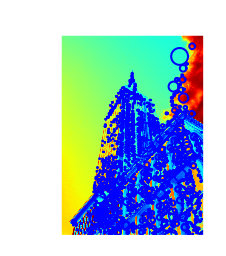

In [19]:
l1,d1 = sift.read_features_from_file('empire.sift')
plot_features(im1,l1,circle=True)

#### sift.py 파일에도 수정된 위의 코드를 반영해주자.

In [20]:
# 반영후

In [21]:
!rm empire.sift

In [22]:
!ls

02_Local_Image_Descriptors.ipynb  harris.py   tmp.pgm
crans_1_small.jpg		  harris.pyc  vlfeat-0.9.20
crans_2_small.jpg		  sift	      vlfeat-0.9.20-bin.tar.gz
empire.jpg			  sift.py
figures				  sift.pyc


In [23]:
sift.process_image(imname,'empire.sift')

vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=empire.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to empire.sift


In [24]:
!ls

02_Local_Image_Descriptors.ipynb  figures     sift.pyc
crans_1_small.jpg		  harris.py   tmp.pgm
crans_2_small.jpg		  harris.pyc  vlfeat-0.9.20
empire.jpg			  sift	      vlfeat-0.9.20-bin.tar.gz
empire.sift			  sift.py


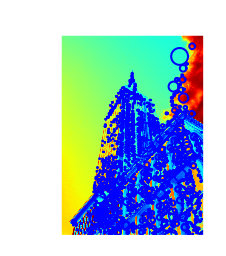

In [25]:
l1,d1 = sift.read_features_from_file('empire.sift')
sift.plot_features(im1,l1,circle=True)

## Matching Descriptors

#### sift.py

In [26]:
def match(desc1,desc2):
    """ For each descriptor in the first image, 
        select its match in the second image.
        input: desc1 (descriptors for the first image), 
        desc2 (same for second image). """
    
    desc1 = array([d/linalg.norm(d) for d in desc1])
    desc2 = array([d/linalg.norm(d) for d in desc2])
    
    dist_ratio = 0.6
    desc1_size = desc1.shape
    
    matchscores = zeros((desc1_size[0]),'int')
    desc2t = desc2.T # precompute matrix transpose
    for i in range(desc1_size[0]):
        dotprods = dot(desc1[i,:],desc2t) # vector of dot products
        dotprods = 0.9999*dotprods
        # inverse cosine and sort, return index for features in second image
        indx = argsort(arccos(dotprods))
        
        # check if nearest neighbor has angle less than dist_ratio times 2nd
        if arccos(dotprods)[indx[0]] < dist_ratio * arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    
    return matchscores

In [27]:
def match_twosided(desc1,desc2):
    """ Two-sided symmetric version of match(). """
    
    matches_12 = match(desc1,desc2)
    matches_21 = match(desc2,desc1)
    
    ndx_12 = matches_12.nonzero()[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0
    
    return matches_12

#### ch2_match_features.py

vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=climbing_1_small.jpg.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to climbing_1_small.jpg.sift
vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=climbing_2_small.jpg.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to climbing_2_small.jpg.sift


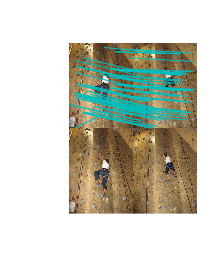

In [29]:
import sift
%matplotlib inline

imname1 = 'climbing_1_small.jpg'
imname2 = 'climbing_2_small.jpg'

# process and save features to file
sift.process_image(imname1, imname1+'.sift')
sift.process_image(imname2, imname2+'.sift')

# read features and match
l1,d1 = sift.read_features_from_file(imname1+'.sift')
l2,d2 = sift.read_features_from_file(imname2+'.sift')
matchscores = sift.match_twosided(d1, d2)

# load images and plot
im1 = array(Image.open(imname1))
im2 = array(Image.open(imname2))

sift.plot_matches(im1,im2,l1,l2,matchscores,show_below=True)

<img src="figures/fig2.5.png" width=600 />

<img src="figures/fig2.6.png" width=600 />

<img src="figures/fig2.7.png" width=600 />

# 2.3 Matching Geotagged Images

* Downloading Geotagged Images from Panoramio
* Matching Using Local Descriptors
* Visualizing Connected Images

## Downloading Geotagged Images from Panoramio

* Panoramio - http://www.panoramio.com/
* Panoramio API - http://www.panoramio.com/api/
    - HTTP GET 호출 - http://www.panoramio.com/map/get_panoramas.php?order=popularity&set=public&from=0&to=20&minx=-77.037564&miny=38.896662&maxx=-77.035564&maxy=38.898662&size=medium

#### 참고 : Advanced REST client

* 크롬 브라우저 플러그인
* https://chrome.google.com/webstore/detail/advanced-rest-client/hgmloofddffdnphfgcellkdfbfbjeloo

<img src="figures/cap_rest-1.png" width=600 />
<img src="figures/cap_rest-2.png" width=600 />

#### ch2_download_panoramio.py

In [30]:
import os
import urllib, urlparse
import simplejson as json

ImportError: No module named simplejson

In [31]:
!pip install simplejson

Downloading/unpacking simplejson
  Running setup.py (path:/home/moosung/.venv/cav/build/simplejson/setup.py) egg_info for package simplejson
    
  Running setup.py install for simplejson
    building 'simplejson._speedups' extension
    gcc -pthread -fno-strict-aliasing -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -fPIC -I/usr/include/python2.7 -c simplejson/_speedups.c -o build/temp.linux-x86_64-2.7/simplejson/_speedups.o
    gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro build/temp.linux-x86_64-2.7/simplejson/_speedups.o -o build/lib.linux-x86_64-2.7/simplejson/_speedups.so
    
Cleaning up...


In [41]:
import os
import urllib, urlparse
import simplejson as json

In [42]:
# query for images
url = 'http://www.panoramio.com/map/get_panoramas.php?order=popularity&\
set=public&from=0&to=20&minx=-77.037564&miny=38.896662&\
maxx=-77.035564&maxy=38.898662&size=medium'
c = urllib.urlopen(url)

In [43]:
# get the urls of individual images from JSON
j = json.loads(c.read())
imurls = []
for im in j['photos']:
    imurls.append(im['photo_file_url'])

In [44]:
# download images
for url in imurls:
    image = urllib.URLopener()
    image.retrieve(url, os.path.basename(urlparse.urlparse(url).path))
    print 'downloading:', url

downloading: http://mw2.google.com/mw-panoramio/photos/medium/43112658.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/105646809.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/588922.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/17651545.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/17651671.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/13512111.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/5752686.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/42748461.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/18739253.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/15646255.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/29206502.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/17651715.jpg
downloading: http://mw2.google.com/mw-panoramio/photos/medium/3725907.jpg
downloading: http://mw2.goog

In [45]:
!ls

02_Local_Image_Descriptors.ipynb  climbing_1_small.jpg
105646809.jpg			  climbing_1_small.jpg.sift
13512111.jpg			  climbing_2_small.jpg
15440152.jpg			  climbing_2_small.jpg.sift
15646255.jpg			  crans_1_small.jpg
1615311.jpg			  crans_2_small.jpg
17651545.jpg			  empire.jpg
17651631.jpg			  empire.sift
17651671.jpg			  figures
17651715.jpg			  harris.py
18739253.jpg			  harris.pyc
23569349.jpg			  panoimages
24265229.jpg			  sift
29206502.jpg			  sift.py
3547633.jpg			  sift.pyc
3725907.jpg			  tmp.pgm
42748461.jpg			  tools
4302047.jpg			  vlfeat-0.9.20
43112658.jpg			  vlfeat-0.9.20-bin.tar.gz
5752686.jpg			  whitehouse.png
588922.jpg


<img src="43112658.jpg" width=300 />

<img src="43112658.jpg" width=300 />
<img src="105646809.jpg" width=300 />
<img src="588922.jpg" width=300 />
<img src="17651545.jpg" width=300 />
<img src="17651671.jpg" width=300 />
<img src="13512111.jpg" width=300 />
<img src="5752686.jpg" width=300 />
<img src="42748461.jpg" width=300 />
<img src="18739253.jpg" width=300 />
<img src="15646255.jpg" width=300 />
<img src="29206502.jpg" width=300 />
<img src="17651715.jpg" width=300 />
<img src="3725907.jpg" width=300 />
<img src="15440152.jpg" width=300 />
<img src="17651631.jpg" width=300 />
<img src="1615311.jpg" width=300 />
<img src="4302047.jpg" width=300 />
<img src="23569349.jpg" width=300 />
<img src="24265229.jpg" width=300 />
<img src="3547633.jpg" width=300 />

<img src="figures/fig2.8.png" width=600 />

## Matching Using Local Descriptors

In [ ]:
import sift
nbr_images = len(imlist)
matchscores = zeros((nbr_images,nbr_images))

for i in range(nbr_images):
    for j in range(i,nbr_images): # only compute upper triangle
        print 'comparing ', imlist[i], imlist[j]
        
            l1,d1 = sift.read_features_from_file(featlist[i])
            l2,d2 = sift.read_features_from_file(featlist[j])

            matches = sift.match_twosided(d1,d2)

            nbr_matches = sum(matches > 0)
            print 'number of matches = ', nbr_matches
            matchscores[i,j] = nbr_matches

# copy values
for i in range(nbr_images):
    for j in range(i+1,nbr_images): # no need to copy diagonal
        matchscores[j,i] = matchscores[i,j]

## Visualizing Connected Images

#### ch2_matching_graph.py

<img src="figures/fig2.9.png" width=600 />

In [37]:
import pydot

ImportError: No module named pydot

In [38]:
!pip install pydot

Downloading/unpacking pydot
  Running setup.py (path:/home/moosung/.venv/cav/build/pydot/setup.py) egg_info for package pydot
    Couldn't import dot_parser, loading of dot files will not be possible.
    
  Running setup.py install for pydot
    Couldn't import dot_parser, loading of dot files will not be possible.
    
Cleaning up...


In [39]:
import pydot

Couldn't import dot_parser, loading of dot files will not be possible.


In [ ]:
# 스택오버플로우 참조 - http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will

In [1]:
!pip uninstall -y pyparsing

Uninstalling pyparsing:
  Successfully uninstalled pyparsing


In [2]:
!pip install -Iv https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz#md5=9be0fcdcc595199c646ab317c1d9a709

Downloading/unpacking https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
...Downloading pyparsing-1.5.7.tar.gz (939kB): 939kB downloaded
  Running setup.py (path:/tmp/pip-OwDHL_-build/setup.py) egg_info for package from https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
    running egg_info
    creating pip-egg-info/pyparsing.egg-info
    writing dependency_links to pip-egg-info/pyparsing.egg-info/dependency_links.txt
    writing pip-egg-info/pyparsing.egg-info/PKG-INFO
    writing top-level names to pip-egg-info/pyparsing.egg-info/top_level.txt
    writing manifest file 'pip-egg-info/pyparsing.egg-info/SOURCES.txt'
    
    reading manifest file 'pip-egg-info/pyparsing.egg-info/SOURCES.txt'
    writing manifest file 'pip-egg-info/pyparsing.egg-info/SOURCES.txt'
  Running setup.py install for pyparsing
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-2.7
    copying pyparsin

In [4]:
!pip uninstall -y pydot

Uninstalling pydot:
  Successfully uninstalled pydot


In [5]:
!pip install pydot

Downloading/unpacking pydot
  Running setup.py (path:/home/moosung/.venv/cav/build/pydot/setup.py) egg_info for package pydot
    
  Running setup.py install for pydot
    
Cleaning up...


In [6]:
import pydot

In [7]:
from pylab import *
from numpy import *
from PIL import Image
%matplotlib inline

In [8]:
!pwd

/home/moosung/pe/study/cav/part1/study03/cvpy


In [23]:
download_path = "panoimages" # set this to the path where you downloaded the panoramio images
path = "/home/moosung/pe/study/cav/part1/study03/cvpy/panoimages/" # path to save thumbnails (pydot needs the full system path)

In [9]:
!mkdir panoimages

In [47]:
!ls

02_Local_Image_Descriptors.ipynb  climbing_1_small.jpg
105646809.jpg			  climbing_1_small.jpg.sift
13512111.jpg			  climbing_2_small.jpg
15440152.jpg			  climbing_2_small.jpg.sift
15646255.jpg			  crans_1_small.jpg
1615311.jpg			  crans_2_small.jpg
17651545.jpg			  empire.jpg
17651631.jpg			  empire.sift
17651671.jpg			  figures
17651715.jpg			  harris.py
18739253.jpg			  harris.pyc
23569349.jpg			  panoimages
24265229.jpg			  sift
29206502.jpg			  sift.py
3547633.jpg			  sift.pyc
3725907.jpg			  tmp.pgm
42748461.jpg			  tools
4302047.jpg			  vlfeat-0.9.20
43112658.jpg			  vlfeat-0.9.20-bin.tar.gz
5752686.jpg			  whitehouse.png
588922.jpg


In [ ]:
# 다운받은 이미지들을 복사하자

In [48]:
!ls panoimages

105646809.jpg  1615311.jpg   17651715.jpg  29206502.jpg  4302047.jpg
13512111.jpg   17651545.jpg  18739253.jpg  3547633.jpg	 43112658.jpg
15440152.jpg   17651631.jpg  23569349.jpg  3725907.jpg	 5752686.jpg
15646255.jpg   17651671.jpg  24265229.jpg  42748461.jpg  588922.jpg


In [ ]:
# 원소스의 PCV/tools 디렉토리를 복사해오자.

In [20]:
!ls

02_Local_Image_Descriptors.ipynb  empire.jpg   sift.py
climbing_1_small.jpg		  empire.sift  sift.pyc
climbing_1_small.jpg.sift	  figures      tmp.pgm
climbing_2_small.jpg		  harris.py    tools
climbing_2_small.jpg.sift	  harris.pyc   vlfeat-0.9.20
crans_1_small.jpg		  panoimages   vlfeat-0.9.20-bin.tar.gz
crans_2_small.jpg		  sift


In [14]:
import sift
from tools import imtools

In [49]:
# list of downloaded filenames
imlist = imtools.get_imlist(download_path)
nbr_images = len(imlist)

In [50]:
imlist

['panoimages/15440152.jpg',
 'panoimages/18739253.jpg',
 'panoimages/588922.jpg',
 'panoimages/17651631.jpg',
 'panoimages/29206502.jpg',
 'panoimages/3725907.jpg',
 'panoimages/43112658.jpg',
 'panoimages/17651545.jpg',
 'panoimages/17651715.jpg',
 'panoimages/23569349.jpg',
 'panoimages/24265229.jpg',
 'panoimages/42748461.jpg',
 'panoimages/105646809.jpg',
 'panoimages/15646255.jpg',
 'panoimages/13512111.jpg',
 'panoimages/4302047.jpg',
 'panoimages/3547633.jpg',
 'panoimages/1615311.jpg',
 'panoimages/5752686.jpg',
 'panoimages/17651671.jpg']

In [51]:
nbr_images

20

In [52]:
# extract features
featlist = [imname[:-3]+'sift' for imname in imlist]
for i,imname in enumerate(imlist):
    sift.process_image(imname, featlist[i])

vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=panoimages/15440152.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to panoimages/15440152.sift
vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=panoimages/18739253.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to panoimages/18739253.sift
vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=panoimages/588922.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to panoimages/588922.sift
vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=panoimages/17651631.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to panoimages/17651631.sift
vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=panoimages/29206502.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to panoimages/29206502.sift
vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=panoimages/3725907.sift --edge-thresh 10 --peak-thresh 5
processed tmp.pgm to panoimages/3725907.sift
vlfeat-0.9.20/bin/glnx86/sift tmp.pgm --output=panoimages/43112658.sift --edge-thresh 10 --peak-thre

In [53]:
!ls panoimages

105646809.jpg	1615311.jpg    17651715.jpg   29206502.jpg   4302047.jpg
105646809.sift	1615311.sift   17651715.sift  29206502.sift  4302047.sift
13512111.jpg	17651545.jpg   18739253.jpg   3547633.jpg    43112658.jpg
13512111.sift	17651545.sift  18739253.sift  3547633.sift   43112658.sift
15440152.jpg	17651631.jpg   23569349.jpg   3725907.jpg    5752686.jpg
15440152.sift	17651631.sift  23569349.sift  3725907.sift   5752686.sift
15646255.jpg	17651671.jpg   24265229.jpg   42748461.jpg   588922.jpg
15646255.sift	17651671.sift  24265229.sift  42748461.sift  588922.sift


In [54]:
matchscores = zeros((nbr_images,nbr_images))

for i in range(nbr_images):
    for j in range(i,nbr_images): # only compute upper triangle
        print 'comparing ', imlist[i], imlist[j]
        l1,d1 = sift.read_features_from_file(featlist[i]) 
        l2,d2 = sift.read_features_from_file(featlist[j])
        matches = sift.match_twosided(d1,d2)
        nbr_matches = sum(matches > 0)
        print 'number of matches = ', nbr_matches 
        matchscores[i,j] = nbr_matches

comparing  panoimages/15440152.jpg panoimages/15440152.jpg
number of matches =  120
comparing  panoimages/15440152.jpg panoimages/18739253.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/588922.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/17651631.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/29206502.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/3725907.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/43112658.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/17651545.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/17651715.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/23569349.jpg
number of matches =  1
comparing  panoimages/15440152.jpg panoimages/24265229.jpg
number of matches =  0
comparing  panoimages/15440152.jpg panoimages/42748461.jpg
number of matches =  0
comparing  panoim

In [55]:
# copy values
for i in range(nbr_images):
    for j in range(i+1,nbr_images): # no need to copy diagonal
        matchscores[j,i] = matchscores[i,j]

In [56]:
matchscores

array([[  1.20000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   7.03000000e+02,   5.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.70000000e+01,   2.00000000e+01,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   5.00000000e+00,   5.23000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00

In [57]:
threshold = 2 # min number of matches needed to create link

In [58]:
g = pydot.Dot(graph_type='graph') # don't want the default directed graph 

In [59]:
for i in range(nbr_images):
    for j in range(i+1,nbr_images):
        if matchscores[i,j] > threshold:
            # first image in pair
            im = Image.open(imlist[i])
            im.thumbnail((100,100))
            filename = path+str(i)+'.png'
            im.save(filename) # need temporary files of the right size 
            g.add_node(pydot.Node(str(i),fontcolor='transparent',shape='rectangle',image=filename))
    
            # second image in pair
            im = Image.open(imlist[j])
            im.thumbnail((100,100))
            filename = path+str(j)+'.png'
            im.save(filename) # need temporary files of the right size 
            g.add_node(pydot.Node(str(j),fontcolor='transparent',shape='rectangle',image=filename)) 
            
            g.add_edge(pydot.Edge(str(i),str(j)))

In [37]:
g.write_png('whitehouse.png')

InvocationException: GraphViz's executables not found

* brew install graphviz
* sudo apt-get install graphviz

In [60]:
g.write_png('whitehouse.png')

True

In [61]:
!ls

02_Local_Image_Descriptors.ipynb  climbing_1_small.jpg
105646809.jpg			  climbing_1_small.jpg.sift
13512111.jpg			  climbing_2_small.jpg
15440152.jpg			  climbing_2_small.jpg.sift
15646255.jpg			  crans_1_small.jpg
1615311.jpg			  crans_2_small.jpg
17651545.jpg			  empire.jpg
17651631.jpg			  empire.sift
17651671.jpg			  figures
17651715.jpg			  harris.py
18739253.jpg			  harris.pyc
23569349.jpg			  panoimages
24265229.jpg			  sift
29206502.jpg			  sift.py
3547633.jpg			  sift.pyc
3725907.jpg			  tmp.pgm
42748461.jpg			  tools
4302047.jpg			  vlfeat-0.9.20
43112658.jpg			  vlfeat-0.9.20-bin.tar.gz
5752686.jpg			  whitehouse.png
588922.jpg


<img src="whitehouse.png" />

<img src="figures/fig2.10.png" width=600 />

# 참고자료

* [1] Programming Computer Vision with Python - http://www.amazon.com/Programming-Computer-Vision-Python-algorithms/dp/1449316549/
* [2] PCV github - https://github.com/jesolem/PCV/